In [44]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
# PARAMS
HBAR        = 1.0
MASS        = 1.0
PBC         = True
N_PARTICLES = 2
N_POINTS    = 2

# Two particles

### Exact Diagonalization

The one body part (kinetic and potential terms) of the hamiltonian in the position basis reads:

$$H = \mathbb{I}\otimes \dots \otimes K_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}+\mathbb{I}\otimes \dots \otimes V_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}$$

Where $K_i \equiv -\frac{\hbar^2}{2m}\nabla_i^2,\quad V_i \equiv V(x_i)$ and $i$ is the index of the particle.

How to construct the hamiltonian: Given a base (in this case distretized positions) $\ket{x_1 x_2...x_p}$ with $p$ particles

$$\hat H = \sum_{i,j,...}\sum_{ i', j', ...}\bra{x_i x_j...}\hat{H}\ket{x_{i'} x_{j'}...}\ket{x_i x_j...}\bra{x_{i'} x_{j'}...}$$

Where $\hat{H} = \sum_{i=1}^P T_i+V_i + \sum_{i<j}U(x_i-y_j)$

With two particles, the matrix elements $\bra{x_i y_j}\hat{H}\ket{x_i y_j}$ are:

$$\bra{x_i y_j}\hat{H}\ket{x_i y_j} = \bra{x_i}T+V\ket{x_j} + \braket{y}$$

$$\hat{H} = \sum_{i_1=1}^N \cdots \sum_{i_P=1}^N \sum_{j_1=1}^N \cdots \sum_{j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$


$$\hat{H} = \sum_{i_1\cdots i_P=1}^N \sum_{j_1\cdots j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$

For 2 particles we have:

$$\hat{H} = \sum_{i_1 i_2 = 1}^2\sum_{j_1 j_2 = 1}^2\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle
\, | x_{i_1} x_{i_2}\rangle \langle x_{j_1} x_{j_2} |$$

Where

$$\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle = \langle x_{i_1} x_{i_2} | T_1+V_1+T_2+V_2+\sum_{i<j}U_{ij} | x_{j_1} x_{j_2} \rangle = $$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\langle{x_{i_2}}|{x_{j_2}}\rangle+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\langle{x_{i_1}}|{x_{j_1}}\rangle+\sum_{i<j} \langle x_{i_1} x_{i_2} |U_{ij}| x_{j_1} x_{j_2} \rangle$$

Using that in position space, the potentials are diagonal: $\langle y| V | x\rangle = V(x)\delta_{xy}$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\delta_{{x_{i_2}}{x_{j_2}}}+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\delta_{{x_{i_1}}x_{j_1}}+\sum_{i<j}U(x_{j_1} x_{j_2})$$

In [46]:
def identity(NGrid):
    """Create the identity operator for N particles."""
    return torch.eye(NGrid, device=device)

II = identity(N_POINTS)

In [47]:
def single_particle_potential(x,V0,K1):
    return V0*torch.sin(K1*x).pow(2)

In [48]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, potential_parameters, x):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = single_particle_potential(x[i],**potential_parameters)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

tensor([0., 1.], device='cuda:0')
tensor([[ 1.0000, -0.5000],
        [-0.5000,  1.0000]], device='cuda:0')
tensor([[ 1.0000,  0.0000, -0.5000, -0.0000],
        [ 0.0000,  1.0000, -0.0000, -0.5000],
        [-0.5000, -0.0000,  1.0000,  0.0000],
        [-0.0000, -0.5000,  0.0000,  1.0000]], device='cuda:0')
tensor([[ 1.0000, -0.5000,  0.0000, -0.0000],
        [-0.5000,  1.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  1.0000, -0.5000],
        [-0.0000,  0.0000, -0.5000,  1.0000]], device='cuda:0')
tensor([[ 2.0000, -0.5000, -0.5000, -0.0000],
        [-0.5000,  2.0000, -0.0000, -0.5000],
        [-0.5000, -0.0000,  2.0000, -0.5000],
        [-0.0000, -0.5000, -0.5000,  2.0000]], device='cuda:0')


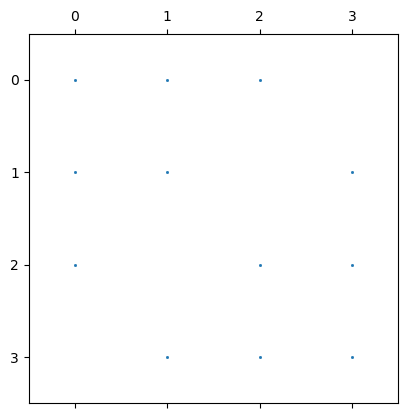

In [67]:
pos = torch.linspace(0, 1, N_POINTS, device=device)
print(pos)
X_i,X_j = torch.meshgrid(pos,pos, indexing='ij')

one_body_hami = hamiltonian_matrix(
    N_POINTS=N_POINTS,
    GRID_SPACING=pos[1] - pos[0],
    PBC=PBC,
    potential_parameters={
        'V0': 1.0,
        'K1': torch.pi
    },
    x=pos
)

print(one_body_hami)
print(torch.kron(one_body_hami,II))
print(torch.kron(II,one_body_hami))

full_onebody_hami = torch.kron(II, one_body_hami)+ torch.kron(one_body_hami, II)
print(full_onebody_hami)
# Plotting the Hamiltonian matrix
plt.spy(full_onebody_hami.cpu(), markersize=1)

In [68]:
def interaction_potential(x1, x2, g):
    """Define the interaction potential between two particles."""
    return g * torch.exp(-((x1 - x2) ** 2)/(2 * 0.5 ** 2))

In [71]:
two_body_matrix = interaction_potential(X_i,X_j,1.0)
print(two_body_matrix)

tensor([[1.0000, 0.1353],
        [0.1353, 1.0000]], device='cuda:0')


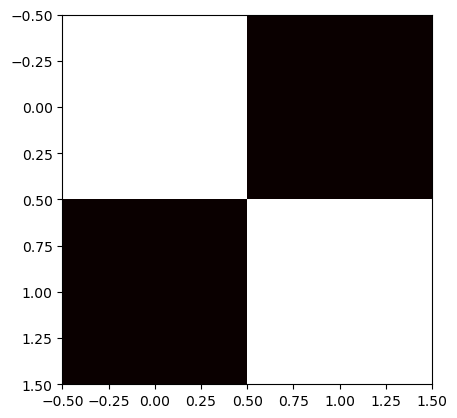

In [70]:
plt.imshow(two_body_matrix.cpu(), cmap='hot', interpolation='nearest')

tensor([[ 3.0000, -0.5000, -0.5000,  0.0000],
        [-0.5000,  2.1353,  0.0000, -0.5000],
        [-0.5000,  0.0000,  2.1353, -0.5000],
        [ 0.0000, -0.5000, -0.5000,  3.0000]], device='cuda:0')


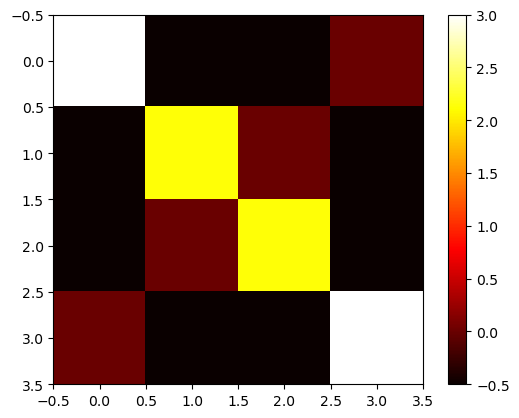

In [72]:
def total_hami(one_body, potential):
    potential_flattened = potential.flatten()
    total_matrix = one_body + torch.diag(potential_flattened)
    return total_matrix
total_matrix = total_hami(full_onebody_hami, two_body_matrix)

plt.imshow((total_matrix).cpu(), cmap='hot')
plt.colorbar()

# define the labels:

labels = []

for i in range(N_POINTS):
    for j in range(N_POINTS):
        labels.append(f"|{i},{j}>")

# Set the labels for the axes
# plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# plt.yticks(ticks=range(len(labels)), labels=labels)
# plt.show();

# only show some labels
# label_spacing = 499
# plt.xticks(ticks=range(0, len(labels), label_spacing), labels=labels[::label_spacing], rotation=90)
# plt.yticks(ticks=range(0, len(labels), label_spacing), labels=labels[::label_spacing])
# plt.xlim(0, 5)
# plt.ylim(0, 5)
;

print(total_matrix)

In [62]:
def get_idx(first_parti, second_parti):
    """Get the index for the state |first_parti, second_parti>."""
    return first_parti * N_POINTS + second_parti

# Example usage of get_idx
i = 0
j = 1
idx = get_idx(i, j)
print(f"Index for state |{i},{j}>: {idx}")

print(f"two_body pot at idx |{i},{j}>: {two_body_matrix[i,j]}")
print(f"flattened two_body pot at idx |{i},{j}>: {two_body_matrix.flatten()[idx]}")

Index for state |0,1>: 1
two_body pot at idx |0,1>: 3.726653176272521e-06
flattened two_body pot at idx |0,1>: 3.726653176272521e-06
